## See Crossing Inventory Data Search for more information. [Link]('https://railroads.dot.gov/safety-data/fra-safety-data-reporting/crossing-inventory-data-search?title=&field_topic_target_id=1311')

Metadata: https://railroads.dot.gov/sites/fra.dot.gov/files/fra_net/3088/datbyfld22802.pdfhttps://railroads.dot.gov/sites/fra.dot.gov/files/fra_net/3088/datbyfld22802.pdf

In [1]:
import urllib
import pandas
import json
import requests
import numpy
import os
import sys
import geopandas
import janitor
from path import Path
import folium
import matplotlib.pyplot as plt
import shapefile

In [2]:
# path configuration
working_directory = Path.getcwd()

inputs_path = working_directory / 'inputs'
outputs_path = working_directory / 'outputs'

In [3]:
# export function
def to_file(callback, desired_name, extension='csv'):
    current_files = sorted(outputs_path.files(desired_name + '*.' + extension))
    if current_files:
        last_file = current_files[-1]
        os.remove(last_file)
    final_name = '{}.{}'.format(desired_name, extension)
    callback(outputs_path / final_name)

In [4]:
# Define the number of items to retrieve per API call
items_per_call = 10

# Initialize a variable to keep track of the current skip value
current_skip = 0

total_items_to_retrieve = 400

# Create an empty list to store the data
data_list = []

### Set up API parameters

In [5]:
# set up api parameters
base_url = "https://safetydata.fra.dot.gov/MasterWebService/PublicApi/frads/v1/odata/gcis"
dataset = 'Crossings'
state_fips = "StateCD eq '29'"
api_key = '7d9f06fbf611c46d2d767ebd72742923'

# by agency ID
agency = 'ReportingAgencyId eq 891'
# by county
county_fips = "CntyCD eq '29037'"
# by railroad
railroad = "OperatingRailroadCode eq 'AM'"

### By State

In [ ]:
# Create a loop to make API calls until you reach the total_items_to_retrieve
while current_skip < total_items_to_retrieve:
    # Build the API endpoint with the current skip value
    endpoint = f"{base_url}/{dataset}?&token={api_key}&$format=json&$filter={state_fips}&$skip={current_skip}"

    # Make the API call here
    response = requests.get(endpoint)
    
    # Check if the API call was successful
    if response.status_code == 200:
        # Convert the API response data to a DataFrame
        api_data = response.json().get('value', [])  # Extract 'value' key
        
        # Extend the data_list with the extracted data
        data_list.extend(api_data)
        
        # Increment the skip value for the next iteration
        current_skip += items_per_call
    else:
        print(f"API request failed with status code {response.status_code}")
        break  # Exit the loop if the API request fails

# Create a DataFrame from the data_list
df = pandas.DataFrame(data_list)

### By Reporting Agency

In [12]:


# Create a loop to make API calls until you reach the total_items_to_retrieve
while current_skip < total_items_to_retrieve:
    # Build the API endpoint with the current skip value
    endpoint = f"{base_url}/{dataset}?&token={api_key}&$format=json&$filter={agency}&$skip={current_skip}"
    # Make the API call here
    response = requests.get(endpoint)
    
    # Check if the API call was successful
    if response.status_code == 200:
        # Convert the API response data to a DataFrame
        api_data = response.json().get('value', [])  # Extract 'value' key
        
        # Extend the data_list with the extracted data
        data_list.extend(api_data)
        
        # Increment the skip value for the next iteration
        current_skip += items_per_call
    else:
        print(f"API request failed with status code {response.status_code}")
        break  # Exit the loop if the API request fails

# Create a DataFrame from the data_list
df = pandas.DataFrame(data_list)

### By county

In [7]:
# Create a loop to make API calls until you reach the total_items_to_retrieve
while current_skip < total_items_to_retrieve:
    # Build the API endpoint with the current skip value
    endpoint = f"{base_url}/{dataset}?&token={api_key}&$format=json&$filter={county_fips}&$skip={current_skip}"

    # Make the API call here
    response = requests.get(endpoint)
    
    # Check if the API call was successful
    if response.status_code == 200:
        # Convert the API response data to a DataFrame
        api_data = response.json().get('value', [])  # Extract 'value' key
        
        # Extend the data_list with the extracted data
        data_list.extend(api_data)
        
        # Increment the skip value for the next iteration
        current_skip += items_per_call
    else:
        print(f"API request failed with status code {response.status_code}")
        break  # Exit the loop if the API request fails

# Create a DataFrame from the data_list
df = pandas.DataFrame(data_list)

### By Railroad

In [6]:
# Create a loop to make API calls until you reach the total_items_to_retrieve
while current_skip < total_items_to_retrieve:
    # Build the API endpoint with the current skip value
    endpoint = f"{base_url}/{dataset}?&token={api_key}&$format=json&$filter={railroad}&$skip={current_skip}"

    # Make the API call here
    response = requests.get(endpoint)
    
    # Check if the API call was successful
    if response.status_code == 200:
        # Convert the API response data to a DataFrame
        api_data = response.json().get('value', [])  # Extract 'value' key
        
        # Extend the data_list with the extracted data
        data_list.extend(api_data)
        
        # Increment the skip value for the next iteration
        current_skip += items_per_call
    else:
        print(f"API request failed with status code {response.status_code}")
        break  # Exit the loop if the API request fails

# Create a DataFrame from the data_list
df = pandas.DataFrame(data_list)

In [8]:
# drop any instance null values from df return for Latitude OR Lnogitude
df = df[~df.Latitude.isna() | ~df.Longitude.isna()]

In [ ]:
 my_geoseries.set_crs(epsg=4326)

In [9]:
#make points spatial
crs="EPSG:4326"

points = geopandas.GeoDataFrame(
    df, crs=crs, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude)
)

# make points float data type
points[['Latitude','Longitude']] = points[['Latitude','Longitude']].astype(float)

In [11]:
# narrow down to zone_points-  290376360 is pleasant hill, 290377600 is stratsburg
zone_points = points[points.CityCD.str.contains('290376360|290377600')]

In [12]:
%store zone_points

Stored 'zone_points' (GeoDataFrame)


In [13]:
# Latitude and Longitude coordinates for Missouri
missouri_coordinates = [38.573936, -92.603760]

# Create a Folium map centered around Missouri
m = folium.Map(location=missouri_coordinates, zoom_start=7)

In [ ]:
folium.Map(location=geopandas.GeoDataFrame(amtrack_routes.geometry + zone_points.geometry), zoom_start=7)

In [14]:
# read in amtrack routes
amtrack_routes = geopandas.read_file(inputs_path/'Amtrak_Routes.geojson')

amtrack_routes.head()

,OBJECTID,NAME,Shape_Leng,Shape_Le_1,ShapeSTLength,geometry
0,1,Acela,7.410105e+05,7.410105e+05,9.779207e+05,"MULTILINESTRING ((-77.01421 38.88360, -77.0137..."
1,2,Adirondack,6.156754e+05,6.156754e+05,8.437497e+05,"MULTILINESTRING ((-73.74197 42.64027, -73.7420..."
2,3,Auto Train,1.474024e+06,1.474024e+06,1.776112e+06,"MULTILINESTRING ((-81.31770 28.75892, -81.3160..."
3,4,Blue Water,5.114384e+05,5.114384e+05,6.939223e+05,"MULTILINESTRING ((-87.63610 41.81772, -87.6361..."
4,5,California Zephyr,4.313889e+06,4.313889e+06,5.672842e+06,"MULTILINESTRING ((-108.55590 39.06263, -108.55..."


In [ ]:
amtrack_routes.geometry.min()

In [15]:
amtrack_routes.NAME.unique()

# filter for particular route and set crs
filtered_routes = amtrack_routes[amtrack_routes.NAME == 'Kansas City - St. Louis (Missouri River Runner)']
filtered_routes = filtered_routes.set_crs(4326, allow_override=True)

In [16]:
# filtered points
filtered_routes

,OBJECTID,NAME,Shape_Leng,Shape_Le_1,ShapeSTLength,geometry
38,39,Kansas City - St. Louis (Missouri River Runner),446399.60129,446399.60129,574665.238931,"LINESTRING (-94.58612 39.08628, -94.58386 39.0..."


<Axes: >

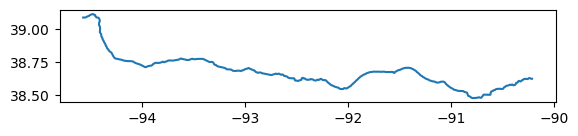

In [20]:
filtered_routes.plot()

In [ ]:
m = folium.Map(location=[your_initial_latitude, your_initial_longitude], zoom_start=your_initial_zoom)


In [ ]:
# Iterate through the GeoDataFrame and add markers for points
for idx, row in zone_points.iterrows():
    # Get the coordinates of the point
    lon, lat = row.geometry.coords[0]
    # Create a marker for each point and add it to the map
    folium.Marker([lat, lon],icon=folium.Icon(icon="cloud")).add_to(m)

# Iterate through the GeoDataFrame and add PolyLines for each LineString geometry
for idx, row in filtered_routes.iterrows():
    # Extract the geometry
    geometry = row.geometry

    # Check if it's a MultiLineString
    if geometry.geom_type == 'MultiLineString':
        for line_string in geometry:
            # Convert each LineString to a list of coordinate pairs
            coordinates = list(line_string.coords)
            
            # Create a PolyLine using the coordinates and add it to the map
            folium.PolyLine(locations=coordinates, color='blue').add_to(m)
    elif geometry.geom_type == 'LineString':
        # Convert the LineString to a list of coordinate pairs
        coordinates = list(geometry.coords)

        # Create a PolyLine using the coordinates and add it to the map
        folium.PolyLine(locations=coordinates, color='blue').add_to(m)
        
# Save the map to an HTML file or display it in a Jupyter Notebook
m.save("map.html")
m

In [ ]:
# Assuming you have a GeoDataFrame called "points" with a "geometry" column containing Point geometries
for idx, row in zone_points.iterrows():
    # Get the coordinates of the point
    lon, lat = row.geometry.coords[0]
    # Create a marker for each point and add it to the map
    folium.Marker([lat, lon],icon=folium.Icon(icon="cloud")).add_to(m)
    
# Save the map to an HTML file or display it in a Jupyter Notebook
m

In [16]:
callback = lambda p: filtered_routes.to_file(p, driver='ESRI Shapefile')
to_file(callback, 'MoDOT_XX_Amtrak_Route', 'shp')

C:\Users\nanzawi\AppData\Local\Temp\ipykernel_1884\1912109623.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  callback = lambda p: filtered_routes.to_file(p, driver='ESRI Shapefile')


In [14]:
callback = lambda p: zone_points.to_file(p, driver='ESRI Shapefile')
to_file(callback, 'MoDOT_XX_Amtrak_Points', 'shp')

C:\Users\nanzawi\AppData\Local\Temp\ipykernel_23716\2044382938.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  callback = lambda p: zone_points.to_file(p, driver='ESRI Shapefile')
